In [1]:
!pip install xbatcher

In [2]:
import torch
import xbatcher
from torch.utils.data import Dataset, DataLoader
import zarr
import numpy as np
import xarray as xr

In [3]:
damage = xr.open_dataset("gs://ads_training_data/damage_xyt/training.zarr", engine="zarr", chunks={})
damage

<xarray.Dataset> Size: 4GB
Dimensions:  (sample: 8241492, window_x: 5, window_y: 5, window_t: 5)
Coordinates:
  * sample   (sample) int64 66MB 0 1 2 3 4 ... 8241488 8241489 8241490 8241491
Dimensions without coordinates: window_x, window_y, window_t
Data variables:
    damage   (sample, window_x, window_y, window_t) float32 4GB dask.array<chunksize=(200000, 5, 5, 5), meta=np.ndarray>

In [4]:
# Based on
# https://github.com/earth-mover/dataloader-demo/blob/main/main.py
class XBatcherPyTorchDataset(Dataset):
    def __init__(self, batch_generator: xbatcher.BatchGenerator):
        self.bgen = batch_generator

    def __len__(self):
        return len(self.bgen)

    def __getitem__(self, idx):
        # load before stacking
        batch = self.bgen[idx].load()

        # Reshape into inputs/outputs.
        # Predictors: all steps in space and up to last
        # step in time.
        X = batch["damage"].values[:, :, :, 0:-1]
        # Output: central cell in space at last
        # step in time.
        y = batch["damage"].values[:, 2, 2, -1]

        # Convert to tensors
        X = torch.tensor(X/100)
        y = torch.tensor(y/100)
        
        return X, y

In [5]:
batcher = xbatcher.BatchGenerator(
    damage,
    input_dims=dict(
        window_x=5,
        window_y=5,
        window_t=5
    ),
    batch_dims=dict(sample=32)
)

# Test
b = batcher[40].load()

In [11]:
torch_ds = XBatcherPyTorchDataset(batcher)
torch_loader = DataLoader(
    torch_ds, 
    batch_size=4,
    shuffle=True,
)

In [13]:
%%time
torch_iter = iter(torch_loader)
for _ in range(10):
    next(torch_iter)

CPU times: user 4.11 s, sys: 2.08 s, total: 6.19 s
Wall time: 13.9 s


In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn

seaborn.set_context("talk")

def parse_log(fname):
    with open(fname) as f:
        lines = f.readlines()

    messages = []
    for line in lines:
        try:
            messages.append(json.loads(line.strip()))
        except json.JSONDecodeError:
            pass
    return messages


def plot_wait_time(messages, ax, title="Time waiting"):
    if title:
        ax.set_title(title)

    wait_times = []
    end = None
    for m in messages:
        if m["event"] == "training end":
            end = m["time"]
        if m["event"] == "training start" and end is not None:
            wait_times.append(m["time"] - end)

    wait_times = np.array(wait_times)
    max_show = wait_times.mean() + 3 * wait_times.std()

    print("average wait time", wait_times.mean())

    ax.hist(wait_times, bins=np.linspace(0, max_show, 100), color="#6D0EDB")[-1]
    ax.set_xlabel("time (sec)")


def plot_log(messages, ax, title=""):
    origin = messages[0]["time"]
    assert messages[0]["event"] == "run start"

    rows = {"setup": 3, "get-batch": 2, "train": 1, "epoch": 0}

    ax.set_yticks(list(rows.values()), labels=list(rows))

    if title:
        ax.set_title(title)

    data = {"batches": []}

    for m in messages:
        t = m["time"] - origin

        if m["event"] == "setup end":
            ax.barh(
                rows["setup"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#6D0EDB",
                zorder=1,
            )

        if m["event"] == "get-batch end":
            ax.barh(
                rows["get-batch"],
                m["duration"],
                left=t - m["duration"],
                # alpha=0.5,
                color="#C396F9",
                zorder=1,
            )
            data["batches"].append(m["duration"])

        if m["event"] == "training end":
            ax.barh(
                rows["train"],
                m["duration"],
                left=t - m["duration"],
                color="#FF6554",
                zorder=1,  # edgecolor="k", linewidth=0.1,
            )

        if m["event"] == "epoch end":
            ax.barh(
                rows["epoch"],
                m["duration"],
                left=t - m["duration"],
                edgecolor="k",
                linewidth=0.1,
                color="#FF9E0D",
                zorder=1,
            )

    ax.grid(axis="x", zorder=0, alpha=0.5)
    ax.set_xlabel("time (sec)")

    print("average batch duration", np.mean(data["batches"]))


def plot(fname):
    messages = parse_log(fname)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6), width_ratios=[3, 1], dpi=400)

    plot_log(messages, axes[0], title="")
    plot_wait_time(messages, axes[1], title="")

    for m in messages:
        if m["event"] == "run start":
            text_str = "\n".join([f"{k}: {v}" for k, v in m["locals"].items() if v is not None])
            props = dict(boxstyle="round", facecolor="#F5F5F5", alpha=0.5)
            fig.text(
                0.5,
                -0.03,
                text_str,
                fontsize=14,
                horizontalalignment="center",
                verticalalignment="top",
                bbox=props,
            )
            break

average batch duration 0.3027732259714344
average wait time 0.21749530385700044


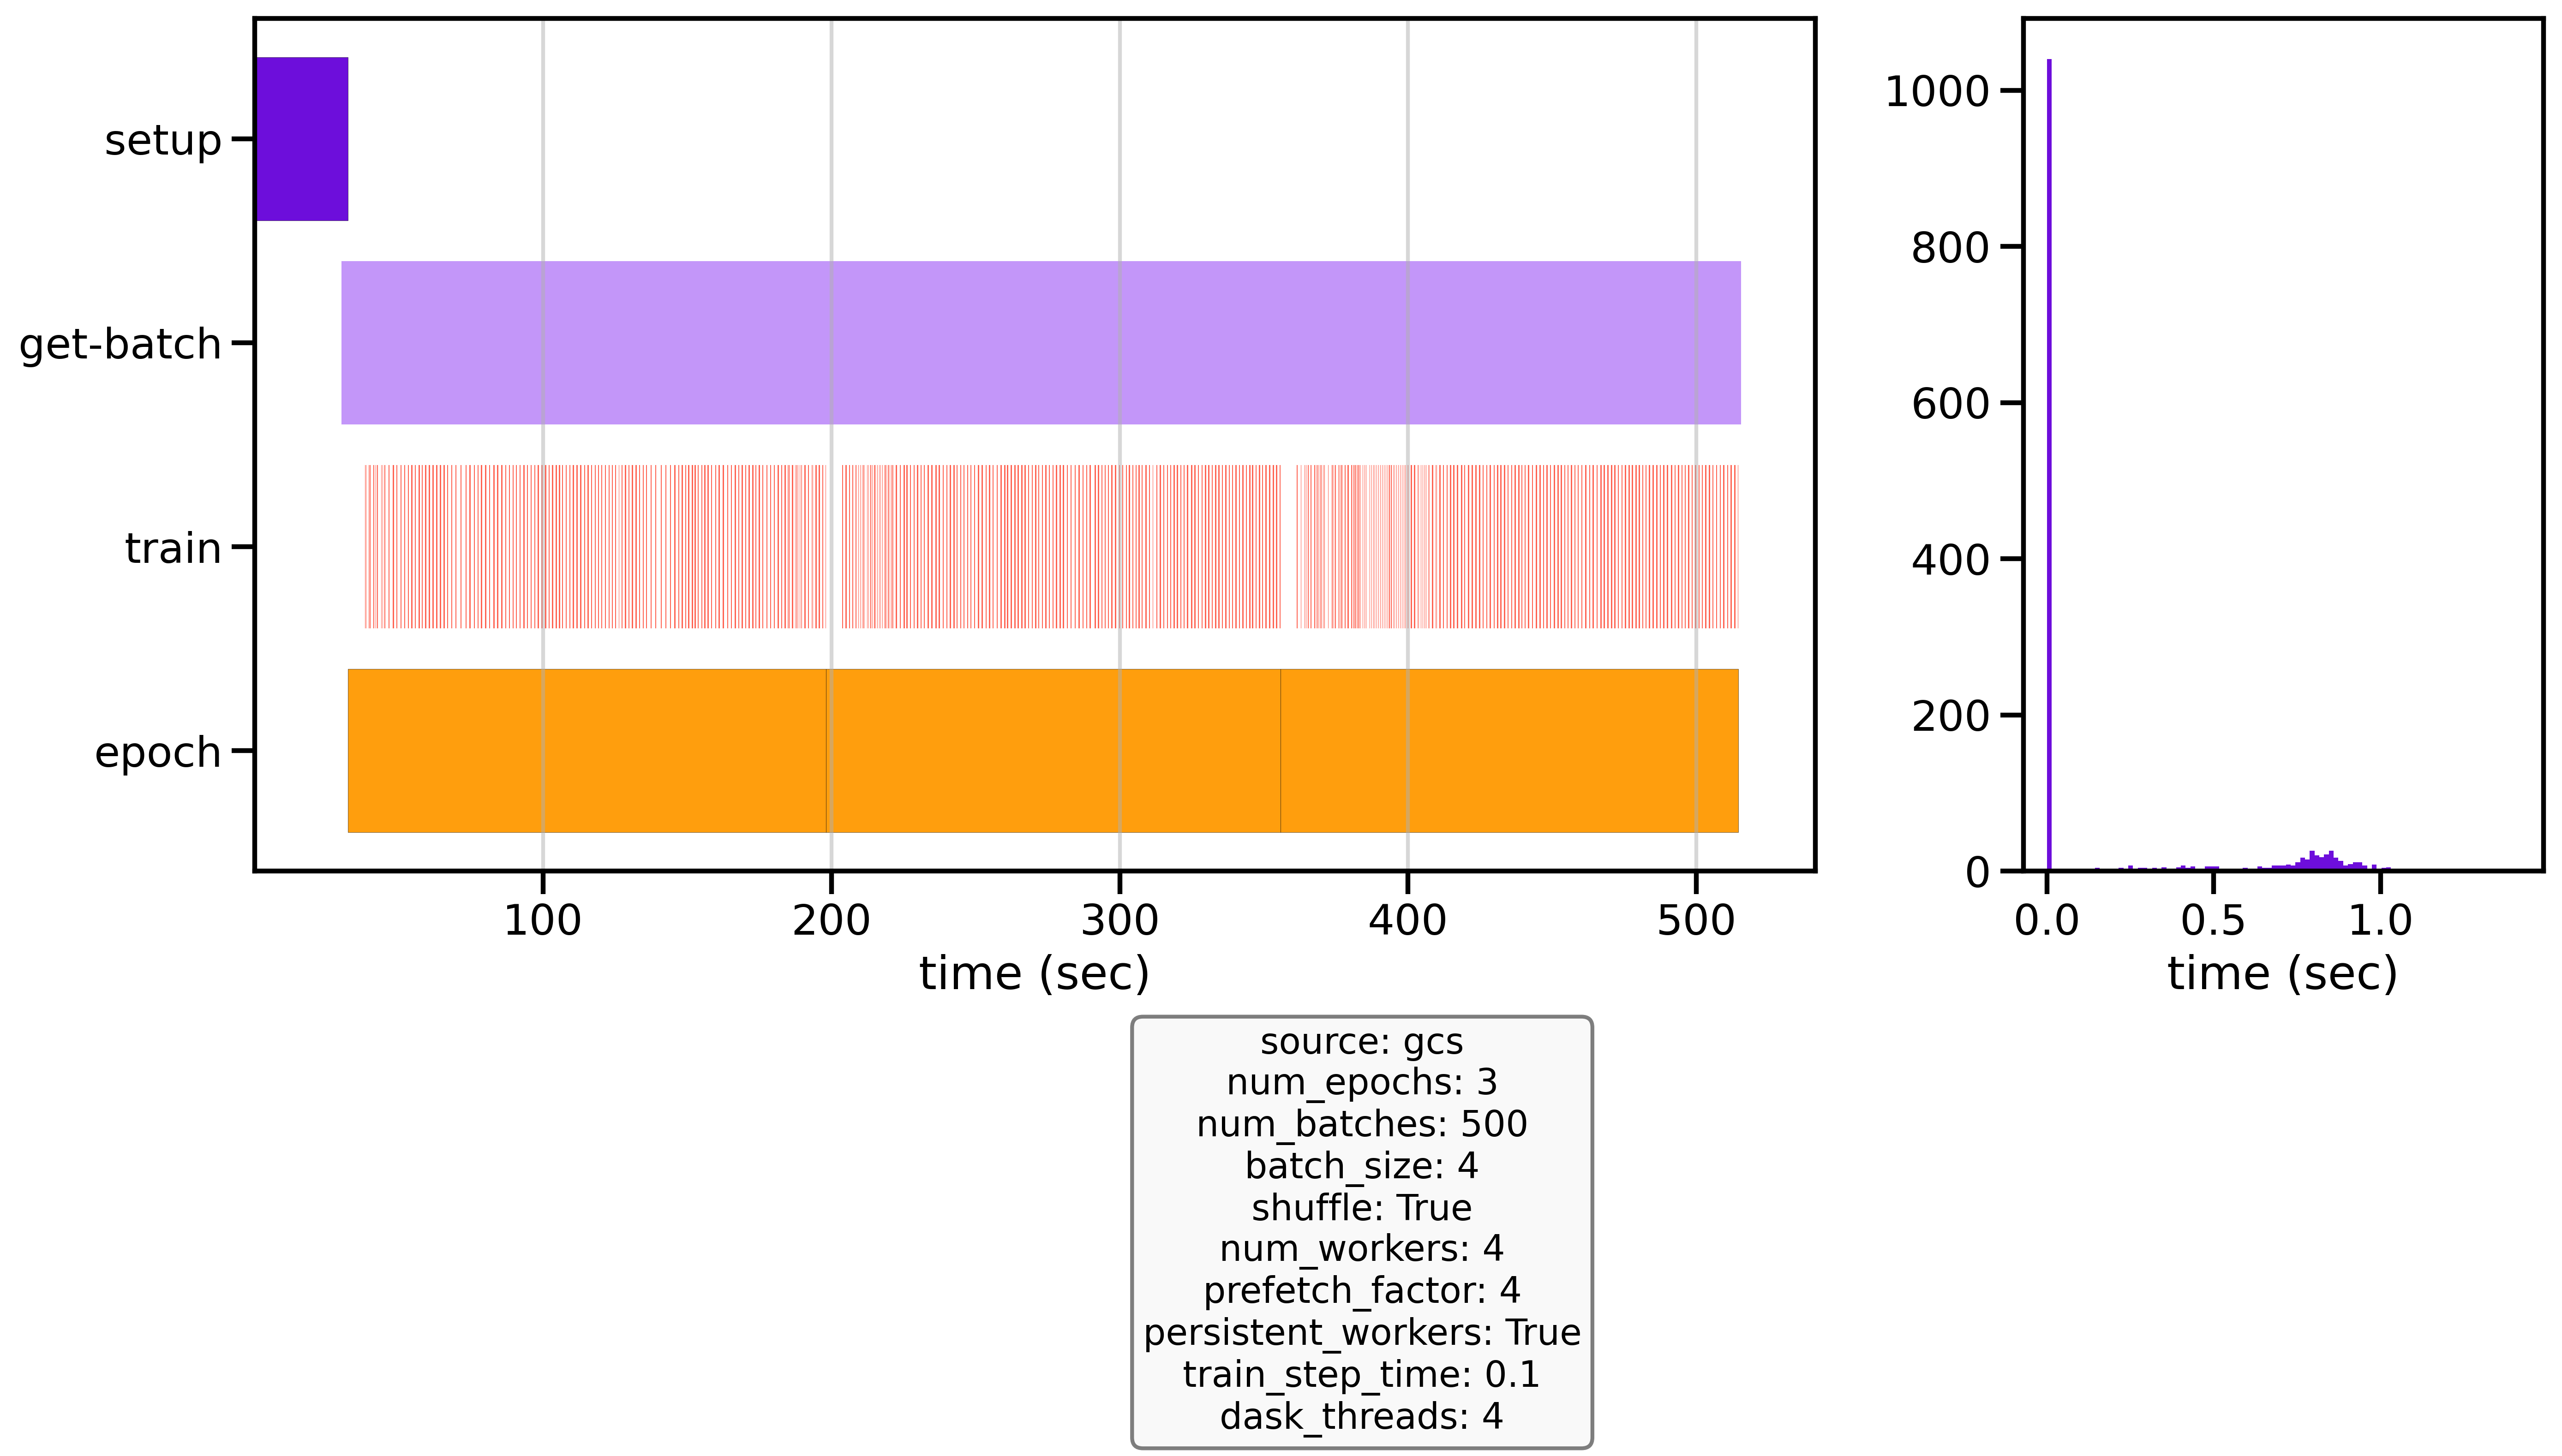

In [5]:
plot("logs/training_benchmark.log")

average batch duration 0.3054778564037499
average wait time 0.21895043813363166


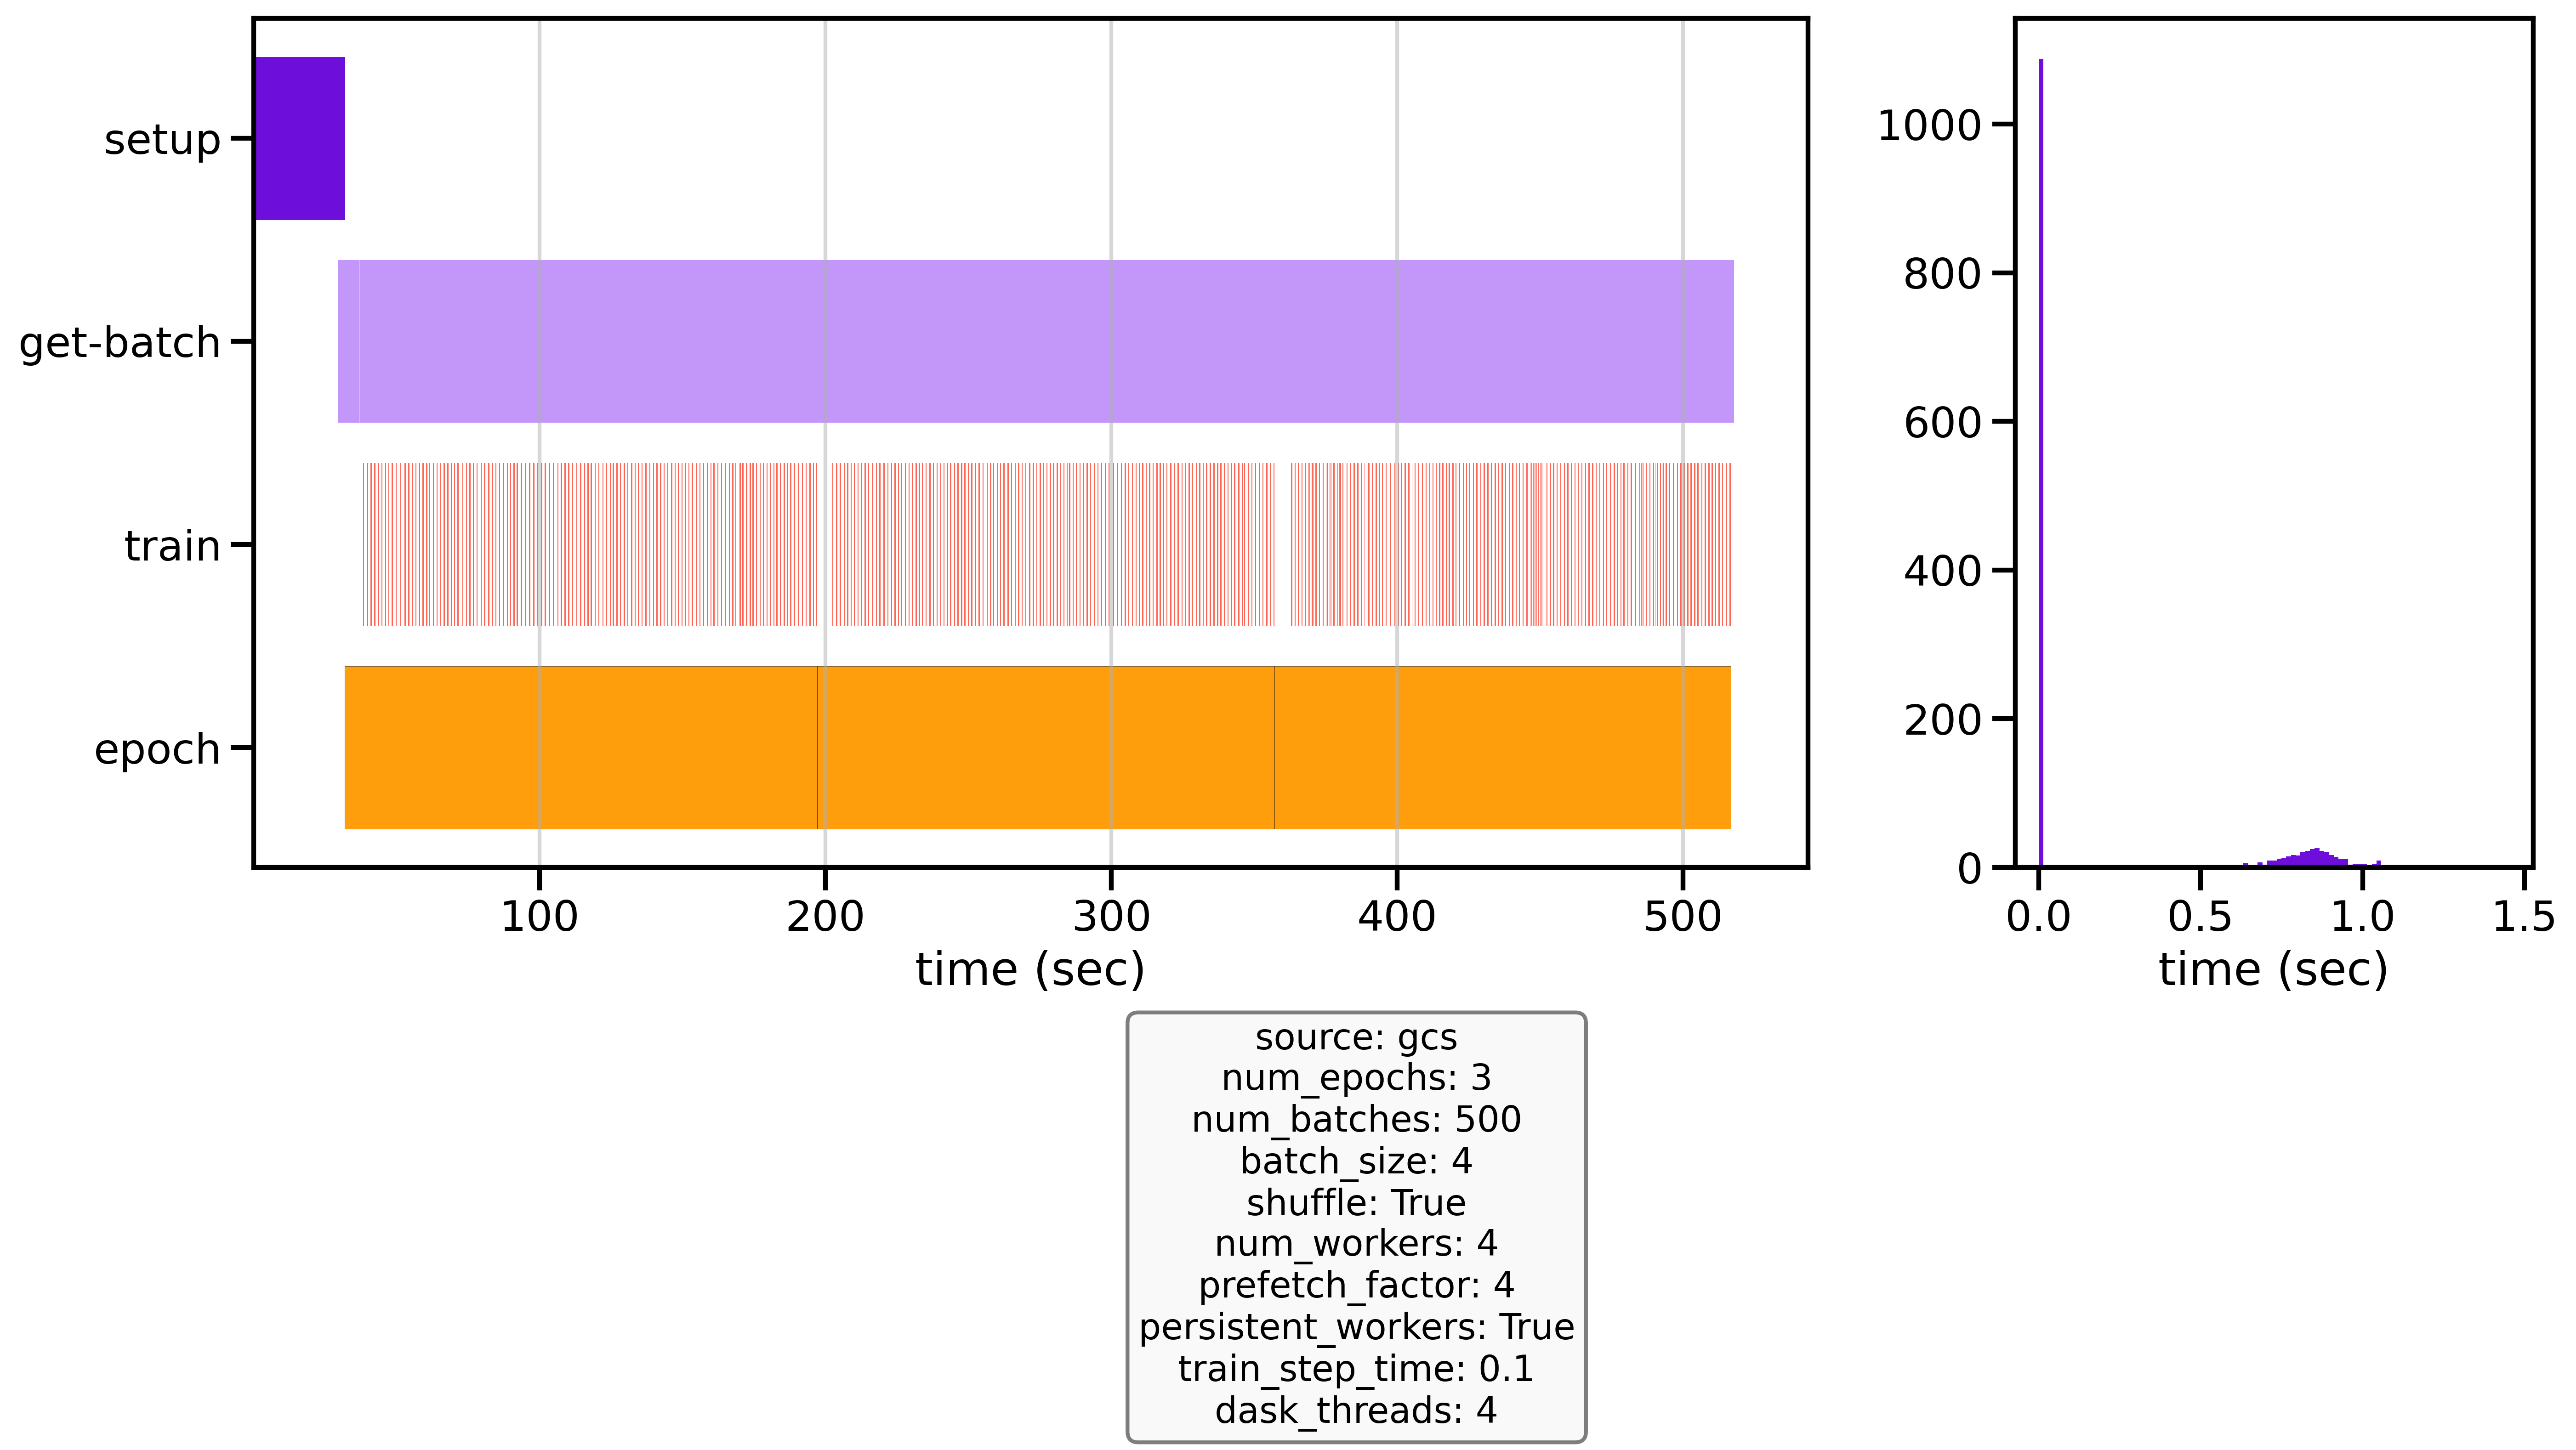

In [6]:
plot("logs/training_benchmark2.log")